In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

# Aplicación de mecánica clásica: Péndulo

Una primera aproximación útil para aplicar el análisis lagrangiano de un problema, independiente de sus componentes vectoriales de fuerza, sería el caso del péndulo ideal simple donde se tiene una partícula de masa $m$ colgando de una cuerda de longitud $l$ cuyo extremo opuesto está fijo a un eje inmóvil:

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Simple_gravity_pendulum.svg" width="300"/>
Sobre este sistema se puede asumir lo siguiente:

- La totalidad de la masa del péndulo es puntual, localizada al extremo de la cuerda. No se tendrá en cuenta la masa de la cuerda, ni el volumen de la partícula o la cuerda.

- La masa está restringida a desplazarse en un camino unidimensional $S$, dónde la longitud del péndulo no cambiará y el único grado de libertad es el ángulo que el péndulo describe respecto al eje vertical.

- No hay fuerzas amortiguadoras como la fricción, resistencia del aire, etc.

Según los postulados de Newton, hallar la ecuación diferencial que describe el movimiento de este péndulo supondría hallar todas las fuerzas que actúan sobre la masa e introducirlas en la ecuación $\sum \vec{F} = m\vec{a}$. Una aproximación independiente de los vectores de fuerza sería hallar la función ***Lagrangiana*** del péndulo, dada por la diferencia de energía cinética y potencial:

Lagrangiano: $L = T - V$

Energía cinética: $T = \frac{1}{2}m v^2$

Energía potencial: $V = mgy$

Al ubicar la coordenada $y = 0$ en el extremo fijo del péndulo, su lagrangiano estará dado por:

$T = \frac{1}{2}m \dot{s}^2 = \frac{1}{2}m l^2\dot{\theta}^2$

$V = -mglcos\theta$

$$ L = \frac{1}{2}m l^2\dot{\theta}^2 + mglcos\theta$$

In [2]:
# Definir variables simbólicas con sympy

t, m, g, l = smp.symbols('t m g l')

theta = smp.symbols(r'\theta', cls = smp.Function) # theta será función del tiempo
theta = theta(t)
theta

\theta(t)

In [3]:
# Derivadas de theta

dTheta = smp.diff(theta, t)
ddTheta = smp.diff(dTheta, t)
ddTheta

Derivative(\theta(t), (t, 2))

In [4]:
# Definir x,y

x,y = smp.symbols('x y', cls = smp.Function)

x = x(theta)
y = y(theta)
x

x(\theta(t))

In [5]:
# Definir el camino x y y parametrizado en theta

path = 'taut'

if path == 'taut':
    x = smp.sin(2*theta) + 2*theta
    y = 1 - smp.cos(2*theta)
    x_f = smp.lambdify(theta, x)
    y_f = smp.lambdify(theta, y)
elif path == 'parab':
    x = theta
    y = theta**2
    x_f = smp.lambdify(theta, x)
    y_f = smp.lambdify(theta, y)
elif path == 'circ':
    x = smp.sin(theta)
    y = smp.cos(theta)
    x_f = smp.lambdify(theta, x)
    y_f = smp.lambdify(theta, y)


In [6]:
# Definir el T, V y L

T = 1/2 * m * (smp.diff(x,t)**2 + smp.diff(y,t)**2)
V = m*g*y

L = T - V
L # Lagrangiano es función de Theta y dTheta

-g*m*(1 - cos(2*\theta(t))) + 0.5*m*((2*cos(2*\theta(t))*Derivative(\theta(t), t) + 2*Derivative(\theta(t), t))**2 + 4*sin(2*\theta(t))**2*Derivative(\theta(t), t)**2)

Habiendo calculado el lagrangiano del problema, se reemplazará en la ecuación de Lagrange para obtener la ecuación de movimiento del péndulo:

$$\frac{d}{dt} \frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0$$

In [7]:
LE = smp.diff(L, theta) - smp.diff(smp.diff(L, dTheta), t)
LE = LE.simplify()
LE

m*(-2.0*g*sin(2*\theta(t)) + 8.0*sin(2*\theta(t))*Derivative(\theta(t), t)**2 - 8.0*cos(2*\theta(t))*Derivative(\theta(t), (t, 2)) - 8.0*Derivative(\theta(t), (t, 2)))

Despejar $\ddot{\theta}$ Para solucionarlo con el ODE solver de *scipy*. En lugar de solucionar una ecuación de primer grado, se pueden solucionar dos ecuaciones de primer grado pasando de $\theta$ a $\omega$:

$$ \frac{d \theta}{dt} = \omega$$
$$\frac{d^2 \theta}{dt^2} = \frac{d \omega}{dt}$$

In [8]:
omega = dTheta
alpha =smp.solve(LE, ddTheta)[0]
alpha

0.25*(-g + 4.0*Derivative(\theta(t), t)**2)*tan(\theta(t))

In [9]:
# OBSERVACIÓN: Tal cual como en la solución en papel del péndulo, las derivadas angulares son independientes de la masa
# Ya concluída la parte simbólica, se utilizan funciones de arrays numéricos de NumPy

deriv2_f = smp.lambdify( (g, theta, dTheta), alpha)
deriv1_f = smp.lambdify(omega, omega)

El sistema puede estar descrito por un vector de dos componentes: Una asociada al ángulo $\theta$, y otro asociado a la velocidad angular $\omega$.

$$S = (\theta,\omega)$$

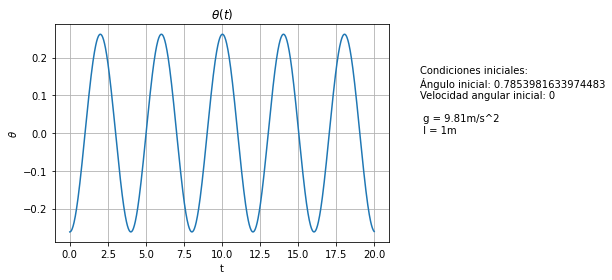

In [13]:
# Crear sistema de EDOs
def dSdt(S, t):
    return [
        deriv1_f(S[1]), #dtheta/dt
        deriv2_f(g, S[0], S[1]) #domega/dt
    ]

# Solucionar el sistema
t = np.linspace(0, 20, 1000)
g = 9.81
ans = odeint(dSdt, y0=[-np.pi/12, 0], t=t)
# y0[0] Es la condición inicial de theta, y0[1] es la condición inicial de omega

plt.plot(t,ans.T[0],) # ans retorna un vector de theta y omega, al transponer y extraer el elemento [0], se extrae theta
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.title(r'$\theta (t)$')
plt.text(23,0,f'Condiciones iniciales:\nÁngulo inicial: {np.pi/4}\nVelocidad angular inicial: {0}\n\n g = 9.81m/s^2\n l = 1m')
plt.show()

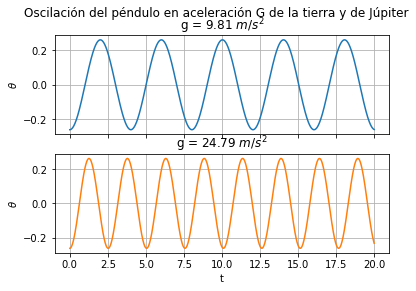

In [11]:
# Poniendo a prueba diferentes valores de g y l:

fig, axs = plt.subplots(2)
fig.suptitle('Oscilación del péndulo en aceleración G de la tierra y de Júpiter\n')

t = np.linspace(0, 20, 1000)
g = 9.81
ans = odeint(dSdt, y0=[-np.pi/12, 0], t=t)
axs[0].grid()
axs[0].plot(t,ans.T[0])
axs[0].set_title(r'g = 9.81 $m/s^2$')

t = np.linspace(0, 20, 1000)
g = 24.79
ans = odeint(dSdt, y0=[-np.pi/12, 0], t=t)
axs[1].grid()
axs[1].plot(t,ans.T[0], 'tab:orange')
axs[1].set_title(r'g = 24.79 $m/s^2$')

for ax in axs.flat:
    ax.set(xlabel='t',ylabel = r"$\theta$")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

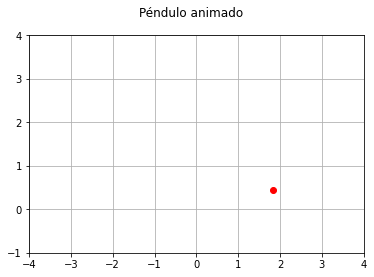

In [14]:
t = np.linspace(0, 20, 1000)
g = 9.81
ans1 = odeint(dSdt, y0=[np.pi/6, 0.4], t=t)

def get_xy(theta):
    return x_f(theta), y_f(theta)

x1, y1 = get_xy(ans1.T[0])

def animate(i):
    ln1.set_data([x1[i]], [y1[i]])
    
fig, ax = plt.subplots(1,1)
ax.grid()
fig.suptitle('Péndulo animado')
ln1, = plt.plot([], [], 'ro')
ax.set_ylim(-1, 4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pendulum.gif',writer='pillow',fps=50)